In [1]:
import warnings

import skrub
from sklearn.ensemble import HistGradientBoostingClassifier
from skrub import TableVectorizer

import sempipes
from sempipes import sem_choose

warnings.filterwarnings("ignore")


sempipes.set_config(
    sempipes.Config(
        llm_for_code_generation=sempipes.LLM(
            name="gemini/gemini-2.5-flash",
            parameters={"temperature": 0.3},
        ),
        llm_for_batch_processing=sempipes.LLM(
            name="ollama/gemma3:1b",
            parameters={"api_base": "http://localhost:11434", "temperature": 0.0},
        ),
    )
)

dataset = skrub.datasets.fetch_midwest_survey()
X = dataset.X.head(n=500)
y = dataset.y.head(n=500)

responses = skrub.var("response", dataset.X)
# responses = responses.skb.subsample(n=500, how="random")
responses = responses.skb.set_description(dataset.metadata["description"])

labels = skrub.var("labels", dataset.y)
# labels = labels.skb.subsample(n=500, how="random")
labels = labels.skb.set_name(dataset.metadata["target"])

responses = responses.skb.mark_as_X()
labels = labels.skb.mark_as_y()

responses_with_additional_features = responses.with_sem_features(
    nl_prompt="""
        Compute additional demographics-related features, use your intrinsic knowledge about the US. 
        Take into account how the identification with the country or regions of it changed over the generations.         
        Also think about how the identification differs per class and education. The midwest is generally associated 
        with "Midwestern values" — friendliness, modesty, hard work, and community-mindedness.
    """,
    name="demographic_features",
    how_many=5,
)

feature_encoder = TableVectorizer()
encoded_responses = responses_with_additional_features.skb.apply(feature_encoder)

learner = HistGradientBoostingClassifier()
model = encoded_responses.skb.apply_with_sem_choose(
    learner,
    y=labels,
    choices=sem_choose(
        "hgb",
        learning_rate="A promising set of learning rates to try",
    ),
)

	> Querying 'gemini/gemini-2.5-flash' with 2 messages...'
	> Computed 5 new feature columns: ['age_group_encoded', 'education_level_encoded', 'is_self_reported_midwestern_resident', 'midwesterner_identification_score', 'num_midwest_states_identified'], removed 0 feature columns: []
--- sempipes.apply_with_sem_choose(HistGradientBoostingClassifier(), SemChoices(name='hgb', params_and_prompts={'learning_rate': 'A promising set of learning rates to try'}))
	> Querying 'gemini/gemini-2.5-flash' with 2 messages...'
	Suggested choices for learning_rate: choose_from([0.1, 0.05, 0.01, 0.2, 0.005, 0.3], name='__sempipes__...learning_rate')


In [2]:
from sempipes.optimisers.olopro import optimise_olopro
from sempipes.optimisers.search_policy import TreeSearch

# Note that this should be done on a separate validation set in a real world use case
outcomes = optimise_olopro(
    model,
    "demographic_features",
    num_trials=12,
    scoring="accuracy",
    search=TreeSearch(min_num_drafts=2),
    cv=5,
    num_hpo_iterations_per_trial=10,
)

	OLOPRO> Computing pipeline summary for context-aware optimisation ---
	OLOPRO> Processing trial 0
	OLOPRO> Initialising optimisation of demographic_features via OPRO
	TREE_SEARCH> Creating root node
	OLOPRO> Evaluating pipeline via 5-fold cross-validation and random search HPO
	OLOPRO>    __sempipes__hgb__learning_rate  mean_test_score
	OLOPRO> 0                           0.100         0.797914
	OLOPRO> 1                           0.200         0.795101
	OLOPRO> 2                           0.050         0.793108
	OLOPRO> 3                           0.010         0.755028
	OLOPRO> 4                           0.005         0.708914
	OLOPRO> 5                           0.300         0.682478
	OLOPRO> Pipeline evaluation took 23.93 seconds
	OLOPRO> Score changed from None to 0.7979139000893353
	OLOPRO> Processing trial 1
	OLOPRO> Evolving operator "demographic_features" via OPRO
	TREE_SEARCH> Drafting new node
	> Querying 'gemini/gemini-2.5-flash' with 4 messages...'
	> Computed 5 new fea

In [3]:
best_outcome = max(outcomes, key=lambda x: x.score)
best_outcome.score

np.float64(0.9322403843832243)

In [4]:
print("\n".join(best_outcome.state["generated_code"]))


import numpy as np
import pandas as pd

# (Numerical encoding of 'How_much_do_you_personally_identify_as_a_Midwesterner')
# Usefulness: Converts a categorical ordinal feature into a numerical representation, allowing the model to capture the strength of self-identification with the Midwest. This directly addresses the prompt's focus on identification.
# Input samples: 'How_much_do_you_personally_identify_as_a_Midwesterner': ['Not much', 'Not much', 'A lot', 'A lot', 'Some', 'Some', 'Some', 'Some', 'Not at all', 'Some']
df['How_much_id_numeric'] = df['How_much_do_you_personally_identify_as_a_Midwesterner'].map({
    'Not at all': 0,
    'Not much': 1,
    'Some': 2,
    'A lot': 3
})

# (Numerical encoding of 'Age')
# Usefulness: Converts age ranges into an ordinal numerical feature. This allows the model to capture generational differences in regional identification, as requested by the prompt ("identification with the country or regions of it changed over the generations").
# Input s

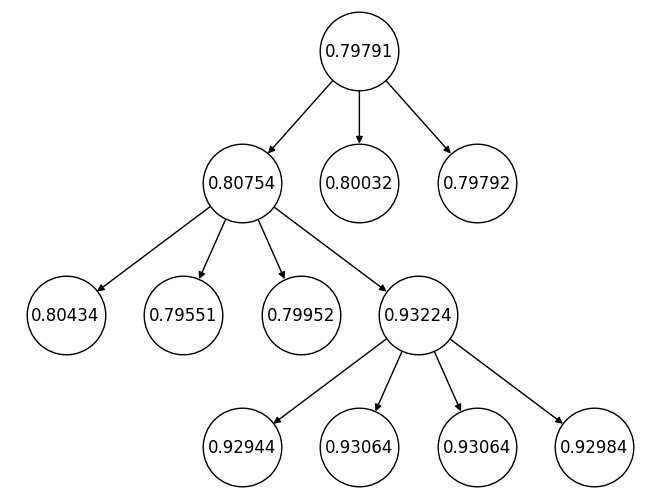

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

attributes = {}
edges = []

for outcome in outcomes:
    node_id = id(outcome.search_node)
    if outcome.search_node.parent is not None:
        parent_node_id = id(outcome.search_node.parent)
        edges.append((parent_node_id, node_id))
    attributes[node_id] = {"score": f"{outcome.score:.5f}"}

G = nx.DiGraph()
G.add_edges_from(edges)
nx.set_node_attributes(G, attributes)

labels = nx.get_node_attributes(G, "score")
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")

nx.draw(
    G,
    pos,
    with_labels=True,
    labels=labels,
    arrows=True,
    node_size=3200,
    node_color="white",
    edgecolors="black",
)
plt.show()